In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq, minimize, minimize_scalar
from scipy.integrate import quad
from scipy.special import expm1
from numpy.polynomial.legendre import leggauss
import warnings
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)
import logging
logging.getLogger("matplotlib.backends.backend_ps").setLevel(logging.ERROR)




ETELL CONTAMINATED TAIL-EXTRAPOLATION SIMULATION
Baseline F₀: ETELL(α=1.0, β=1.0, θ=2.0)
  Tail index ξ₀ = 1.000
Contaminating Fᶜ: ETELL(α=3.0, β=1.0, θ=2.0)
  Tail index ξᶜ = 0.333
Sample size: n = 100
Monte Carlo replications: m = 10000
----------------------------------------------------------------------
True values at baseline:
  xi: 1.0000
  VaR: 40.0000
  TVaR: 502.6131
  PHDRM: 33.1036
L-estimators...
 J(1,0.6)...  J(1,0.7)...  J(1,0.88)...  J(1,0.9)...  J(1,0.92)... 
Running ε = 0.00...
  Replication 2000/10000
  Replication 4000/10000
  Replication 6000/10000
  Replication 8000/10000
  Replication 10000/10000
Running ε = 0.05...
  Replication 2000/10000
  Replication 4000/10000
  Replication 6000/10000
  Replication 8000/10000
  Replication 10000/10000
Running ε = 0.10...
  Replication 2000/10000
  Replication 4000/10000
  Replication 6000/10000
  Replication 8000/10000
  Replication 10000/10000

Simulation complete!

SUMMARY: Median estimates across Monte Carlo replications

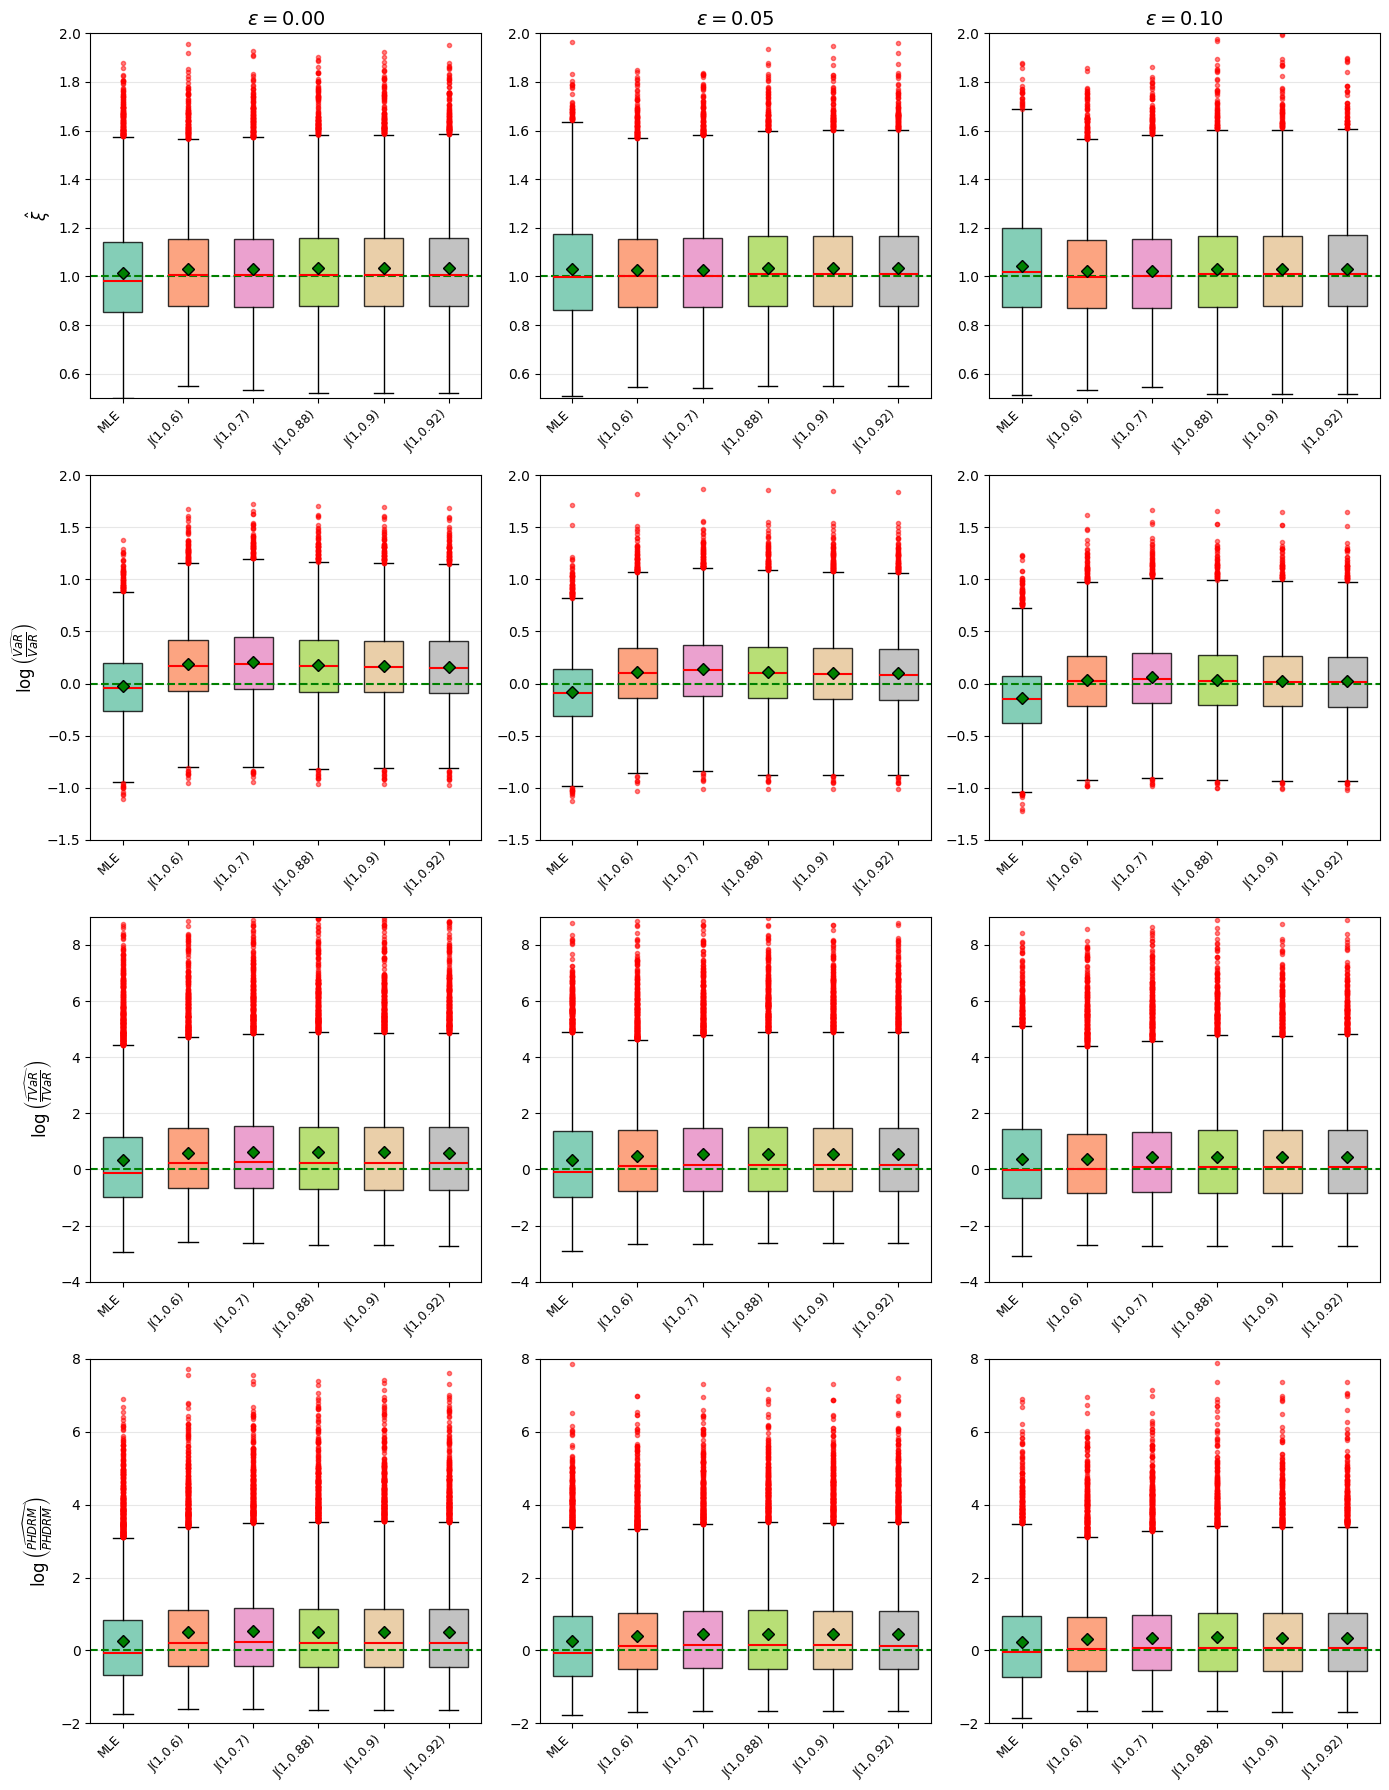


Figure saved to: etell_contaminated_simulation.eps


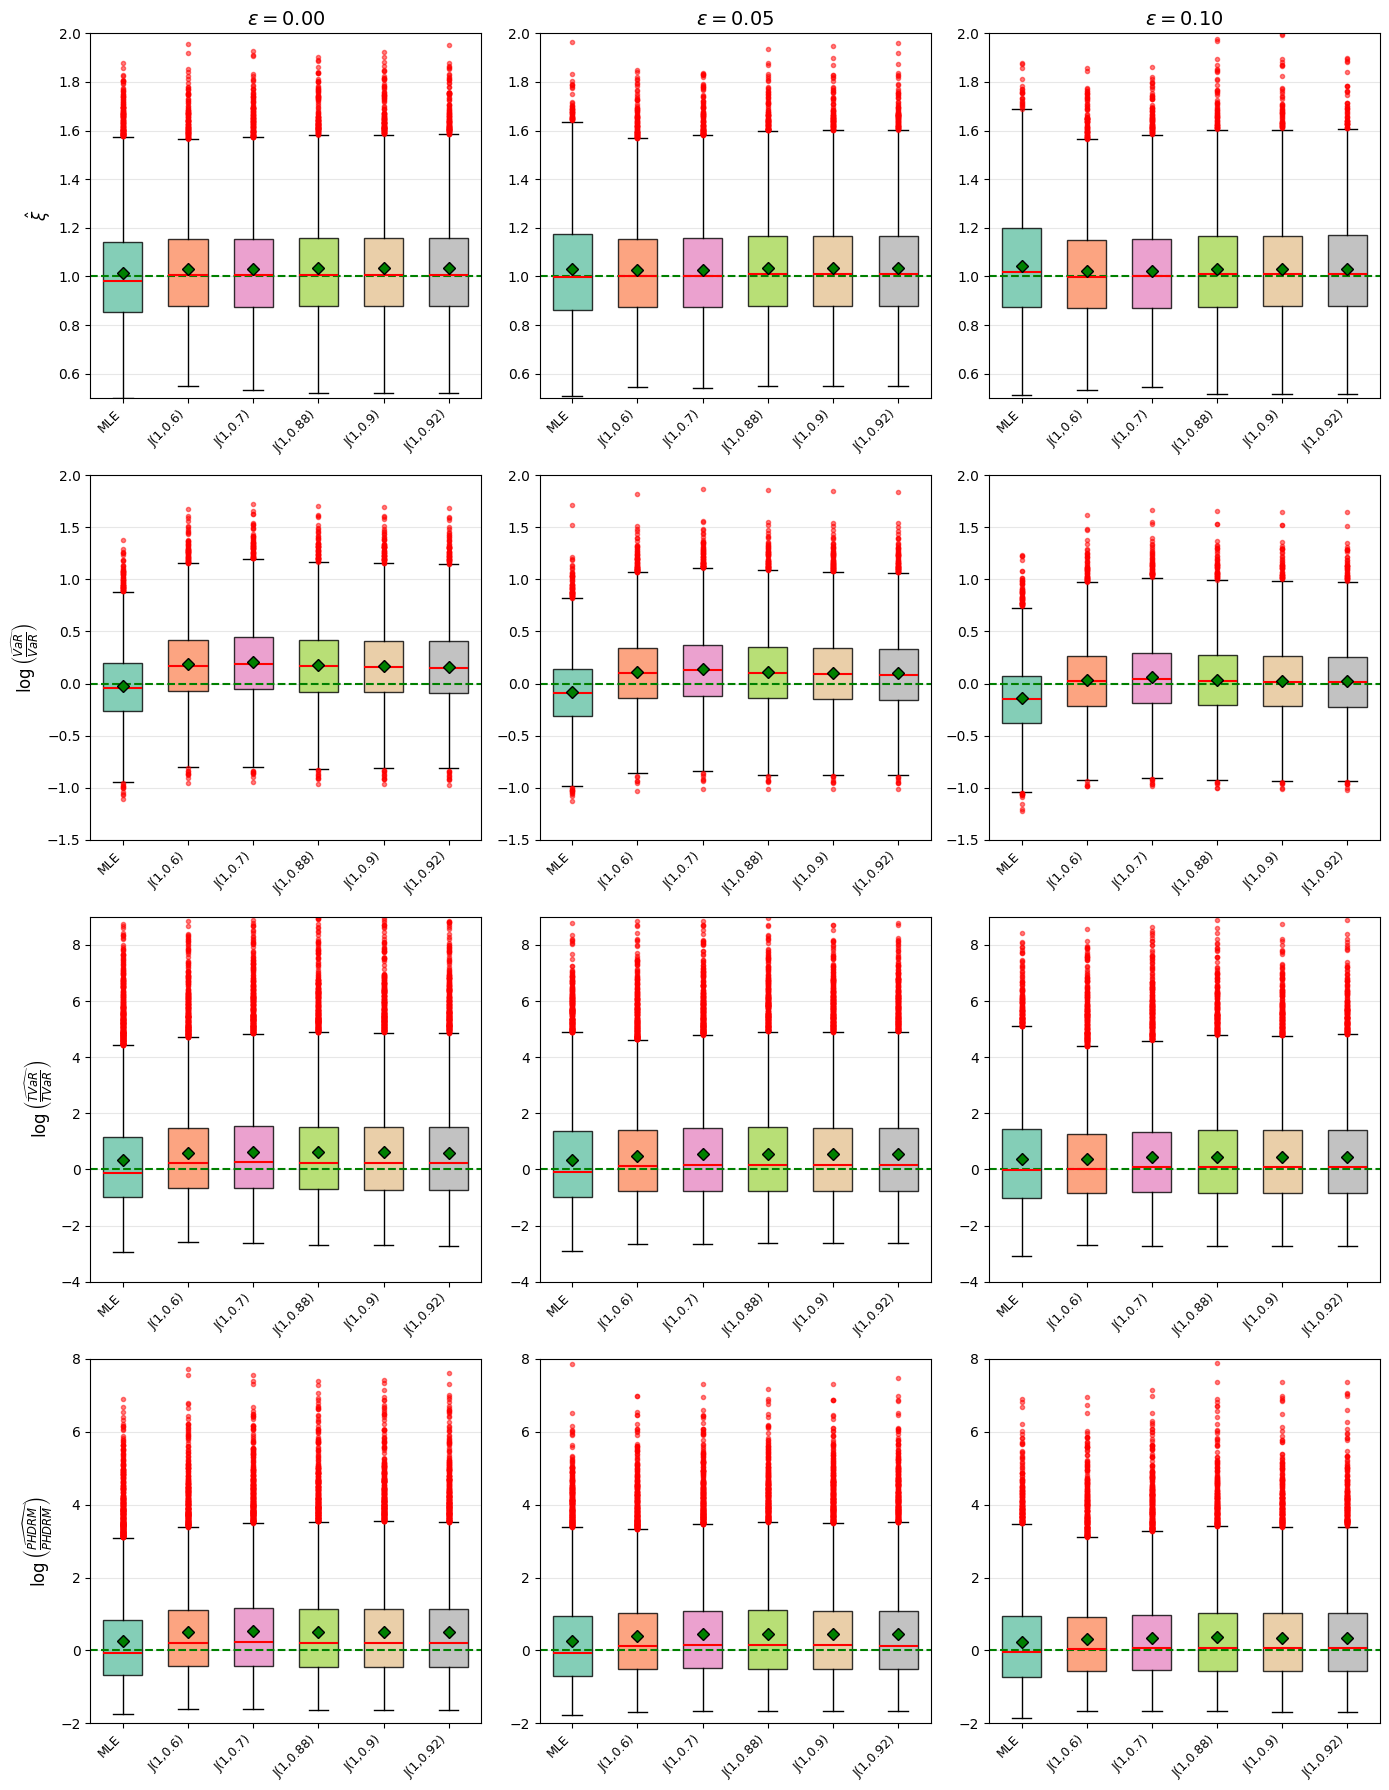


⏱️ Total runtime: 10776.8 seconds


In [ ]:
"""
ETELL Contaminated Tail-Extrapolation Simulation
==================================================================
With mean markers (green diamonds) on boxplots
"""


class ETELLContaminationSimulation:
    """
    ETELL distribution simulation with contamination model
    """

    def __init__(self, theta=2.0, alpha=1.0, beta=1.0, n_sample=100, n_quad=300, rng=None):
        self.theta = float(theta)
        self.alpha_true = float(alpha)
        self.beta_true = float(beta)
        self.n_sample = n_sample

        nodes, weights = leggauss(n_quad)
        self.u_quad = 0.5 * (nodes + 1.0)
        self.w_quad = 0.5 * weights

        self.rng = np.random.default_rng(rng)
        self.calibration_factors = {}

    @staticmethod
    def kumaraswamy_weight(u, a, b):
        u = np.clip(u, 1e-12, 1 - 1e-12)
        return a * b * (u ** (a - 1)) * ((1 - u ** a) ** (b - 1))

    def quantile(self, u, alpha, beta):
        u = np.asarray(u, dtype=float)
        u = np.clip(u, 1e-12, 1 - 1e-12)
        two_b = 2.0 ** beta
        base = np.maximum(two_b - (two_b - 1.0) * u, 1e-300)
        t = np.maximum(np.power(base, 1.0 / beta) - 1.0, 1e-300)
        return self.theta * np.power(t, -1.0 / alpha)

    def generate_sample(self, n, alpha, beta):
        u = self.rng.uniform(0.0, 1.0, int(n))
        return self.quantile(u, alpha, beta)

    def generate_contaminated_sample(self, n, epsilon, alpha_c, beta_c):
        n_contaminated = self.rng.binomial(n, epsilon)
        n_baseline = n - n_contaminated
        x_baseline = self.generate_sample(n_baseline, self.alpha_true, self.beta_true)
        x_contaminated = self.generate_sample(n_contaminated, alpha_c, beta_c)
        x = np.concatenate([x_baseline, x_contaminated])
        self.rng.shuffle(x)
        return x

    def compute_ck(self, beta, k, a, b):
        J = self.kumaraswamy_weight(self.u_quad, a, b)
        two_b = 2.0 ** beta
        base = two_b - (two_b - 1.0) * self.u_quad
        xi = np.power(base, 1.0/beta) - 1.0
        log_xi = np.log(np.maximum(xi, 1e-300))
        return np.sum(self.w_quad * J * np.power(log_xi, k))

    def tau(self, beta, a, b):
        c1 = self.compute_ck(beta, 1, a, b)
        c2 = self.compute_ck(beta, 2, a, b)
        return c2 - c1 ** 2

    def calibrate_l_estimator(self, a, b, n_calib=3000):
        print(f" J({a},{b})...", end=" ", flush=True)
        calib_rng = np.random.default_rng(99999)
        xi_estimates = []

        for _ in range(n_calib):
            u = calib_rng.uniform(0, 1, self.n_sample)
            x = self.quantile(u, self.alpha_true, self.beta_true)
            alpha_raw, beta_raw = self._l_estimator_raw(x, a, b)
            if np.isfinite(alpha_raw) and 0.05 < alpha_raw < 20:
                xi_raw = 1.0 / alpha_raw
                xi_estimates.append(xi_raw)

        if len(xi_estimates) > 100:
            median_raw = np.median(xi_estimates)
            correction = (1.0 / self.alpha_true) / median_raw
            return correction
        print("failed, using 1.0")
        return 1.0

    def _l_estimator_raw(self, x, a, b):
        x = np.asarray(x, dtype=float)
        x = x[x >= self.theta]
        n_actual = len(x)

        if n_actual < 5:
            return np.nan, np.nan

        xs = np.sort(x)
        uo = np.arange(1, n_actual + 1) / (n_actual + 1.0)
        J = self.kumaraswamy_weight(uo, a, b)

        lx = np.log(xs)
        mu1 = np.mean(J * lx)
        mu2 = np.mean(J * lx ** 2)
        Delta = mu2 - mu1 ** 2

        if Delta <= 1e-12:
            return np.nan, np.nan

        target = (np.log(self.theta) - mu1) / np.sqrt(Delta)

        def R(beta):
            c1 = self.compute_ck(beta, 1, a, b)
            t = self.tau(beta, a, b)
            if t <= 1e-12:
                return np.nan
            return c1 / np.sqrt(t) - target

        for lo, hi in [(-2, 0), (0, 2), (-3, 3), (-1, 1)]:
            try:
                r_lo, r_hi = R(lo), R(hi)
                if np.isfinite(r_lo) and np.isfinite(r_hi) and r_lo * r_hi < 0:
                    beta_hat = brentq(R, lo, hi, xtol=1e-7)
                    t_beta = self.tau(beta_hat, a, b)
                    if t_beta > 0:
                        alpha_hat = np.sqrt(t_beta / Delta)
                        if 0.05 < alpha_hat < 20:
                            return alpha_hat, beta_hat
            except:
                continue
        return np.nan, np.nan

    def l_estimator(self, x, a, b):
        alpha_raw, beta_hat = self._l_estimator_raw(x, a, b)
        if not np.isfinite(alpha_raw):
            return np.nan, np.nan
        key = (a, b)
        if key in self.calibration_factors:
            alpha_corrected = alpha_raw / self.calibration_factors[key]
            return alpha_corrected, beta_hat
        return alpha_raw, beta_hat

    def mle(self, x):
        x = np.asarray(x, dtype=float)
        x = x[x >= self.theta]
        n_obs = len(x)

        if n_obs < 5:
            return np.nan, np.nan

        def neg_loglik(params):
            alpha, beta = params
            if alpha <= 0.01 or abs(beta) > 5:
                return 1e10
            try:
                two_b = 2.0 ** beta
                const = np.log(abs(beta)) - np.log(abs(two_b - 1.0))
                ratio = (self.theta / x) ** alpha
                ll = n_obs * np.log(alpha) + n_obs * const
                ll += (beta - 1.0) * np.sum(np.log1p(ratio))
                ll -= (1.0 + alpha) * np.sum(np.log(x / self.theta))
                return -ll if np.isfinite(ll) else 1e10
            except:
                return 1e10

        best_result, best_nll = None, np.inf
        for a0 in [0.5, 1.0, 2.0]:
            for b0 in [0.5, 1.0, -0.5]:
                try:
                    res = minimize(neg_loglik, [a0, b0],
                                   bounds=[(0.05, 15.0), (-3.0, 3.0)],
                                   method="L-BFGS-B")
                    if res.success and res.fun < best_nll:
                        best_nll = res.fun
                        best_result = res.x
                except:
                    continue

        if best_result is not None and best_result[0] > 0:
            return best_result[0], best_result[1]
        return np.nan, np.nan

    def compute_VaR(self, alpha, beta, p=0.95):
        return self.quantile(p, alpha, beta)

    def compute_TVaR(self, alpha, beta, p=0.95, n_quad=300):
        nodes, weights = leggauss(n_quad)
        u = 0.5 * (1 - p) * (nodes + 1) + p
        w = 0.5 * (1 - p) * weights
        q_vals = self.quantile(u, alpha, beta)
        return np.sum(w * q_vals) / (1 - p)

    def compute_PHDRM(self, alpha, beta, p=0.95, n_quad=300):
        nodes, weights = leggauss(n_quad)
        u = 0.5 * (nodes + 1)
        w = 0.5 * weights
        q_vals = self.quantile(u, alpha, beta)
        distortion_weights = p * np.power(np.maximum(1 - u, 1e-10), p - 1)
        return np.sum(w * q_vals * distortion_weights)

    def compute_tail_index(self, alpha):
        return 1.0 / alpha

    def compute_all_functionals(self, alpha, beta, p=0.95):
        return {
            'xi': self.compute_tail_index(alpha),
            'VaR': self.compute_VaR(alpha, beta, p),
            'TVaR': self.compute_TVaR(alpha, beta, p),
            'PHDRM': self.compute_PHDRM(alpha, beta, p)
        }

    def run_simulation(self, n_reps=10000, p=0.95,
                       alpha_c=3.0, beta_c=1.0,
                       epsilon_values=[0.0, 0.05, 0.10],
                       kuma_params=None,
                       verbose=True):

        if kuma_params is None:
            kuma_params = [(1, 0.6), (1, 0.7), (1, 0.88), (1, 0.9), (1, 0.92)]

        true_values = self.compute_all_functionals(self.alpha_true, self.beta_true, p)

        if verbose:
            print("=" * 70)
            print(f"Baseline F₀: ETELL(α={self.alpha_true}, β={self.beta_true}, θ={self.theta})")
            print(f"  Tail index ξ₀ = {1/self.alpha_true:.3f}")
            print(f"Contaminating Fᶜ: ETELL(α={alpha_c}, β={beta_c}, θ={self.theta})")
            print(f"  Tail index ξᶜ = {1/alpha_c:.3f}")
            print(f"Sample size: n = {self.n_sample}")
            print(f"Monte Carlo replications: m = {n_reps}")
            print("-" * 70)
            print("True values at baseline:")
            for key, val in true_values.items():
                print(f"  {key}: {val:.4f}")
            print("=" * 70)

            print("L-estimators...")
            for a, b in kuma_params:
                self.calibration_factors[(a, b)] = self.calibrate_l_estimator(a, b)
            print()

        estimator_names = ['MLE'] + [f'J({a},{b})' for a, b in kuma_params]
        functional_names = ['xi', 'VaR', 'TVaR', 'PHDRM']

        results = {}
        for eps in epsilon_values:
            results[eps] = {}
            for est_name in estimator_names:
                results[eps][est_name] = {fn: [] for fn in functional_names}

        for eps in epsilon_values:
            if verbose:
                print(f"Running ε = {eps:.2f}...")

            for rep in range(n_reps):
                if verbose and (rep + 1) % 2000 == 0:
                    print(f"  Replication {rep + 1}/{n_reps}")

                x = self.generate_contaminated_sample(self.n_sample, eps, alpha_c, beta_c)

                alpha_mle, beta_mle = self.mle(x)
                if np.isfinite(alpha_mle) and np.isfinite(beta_mle) and 0.05 < alpha_mle < 20:
                    funcs = self.compute_all_functionals(alpha_mle, beta_mle, p)
                    for fn in functional_names:
                        if np.isfinite(funcs[fn]) and funcs[fn] > 0:
                            results[eps]['MLE'][fn].append(funcs[fn])

                for a, b in kuma_params:
                    alpha_L, beta_L = self.l_estimator(x, a, b)
                    if np.isfinite(alpha_L) and np.isfinite(beta_L) and 0.05 < alpha_L < 20:
                        funcs = self.compute_all_functionals(alpha_L, beta_L, p)
                        est_name = f'J({a},{b})'
                        for fn in functional_names:
                            if np.isfinite(funcs[fn]) and funcs[fn] > 0:
                                results[eps][est_name][fn].append(funcs[fn])

        for eps in epsilon_values:
            for est_name in estimator_names:
                for fn in functional_names:
                    results[eps][est_name][fn] = np.array(results[eps][est_name][fn])

        if verbose:
            print("\nSimulation complete!")
            self._print_summary(results, true_values, epsilon_values,
                              estimator_names, functional_names)

        return results, true_values, estimator_names

    def _print_summary(self, results, true_values, epsilon_values,
                       estimator_names, functional_names):
        print("\n" + "=" * 90)
        print("SUMMARY: Median estimates across Monte Carlo replications")
        print("=" * 90)

        for fn in functional_names:
            print(f"\n{fn.upper()} (True value: {true_values[fn]:.4f})")
            print("-" * 80)
            header = f"{'Estimator':<12}"
            for eps in epsilon_values:
                header += f"{'ε=' + str(eps):>25}"
            print(header)

            for est_name in estimator_names:
                row = f"{est_name:<12}"
                for eps in epsilon_values:
                    vals = results[eps][est_name][fn]
                    if len(vals) > 0:
                        med = np.median(vals)
                        iqr = np.percentile(vals, 75) - np.percentile(vals, 25)
                        row += f"{med:10.4f} (IQR:{iqr:8.3f})  "
                    else:
                        row += f"{'N/A':>25}"
                print(row)

    def create_boxplots(self, results, true_values, epsilon_values,
                                  estimator_names, figsize=(16, 14), save_path=None):
        """
        Create 4×3 boxplot matrix:
        - Row 1 (ξ): Raw estimates with y-axis
        - Row 2-4 (VaR, TVaR, PHDRM): Log-ratio with y-axis based on data
        - Green diamonds show the MEAN
        - Red line shows the MEDIAN
        """

        functional_names = ['xi', 'VaR', 'TVaR', 'PHDRM']
        functional_labels = {
            'xi': r'$\hat{\xi}$',
            'VaR': r'$\log\left(\frac{\widehat{VaR}}{VaR}\right)$',
            'TVaR': r'$\log\left(\frac{\widehat{TVaR}}{TVaR}\right)$',
            'PHDRM': r'$\log\left(\frac{\widehat{PHDRM}}{PHDRM}\right)$'
        }

        fig, axes = plt.subplots(4, 3, figsize=figsize)

        n_est = len(estimator_names)
        colors = plt.cm.Set2(np.linspace(0, 1, n_est))

        # First pass: collect all data to determine y-limits for each row
        all_data_by_row = {fn: [] for fn in functional_names}

        for fn in functional_names:
            true_val = true_values[fn]
            for eps in epsilon_values:
                for est_name in estimator_names:
                    vals = results[eps][est_name][fn]
                    if len(vals) > 0:
                        if fn == 'xi':
                            # Raw values for tail index
                            all_data_by_row[fn].extend(vals)
                        else:
                            # Log-ratio for risk measures
                            log_ratio = np.log(vals / true_val)
                            valid = log_ratio[np.isfinite(log_ratio)]
                            all_data_by_row[fn].extend(valid)

        # Compute y-limits for each row based on percentiles
        ylims = {}
        for fn in functional_names:
            data = np.array(all_data_by_row[fn])
            if len(data) > 0:
                # Use 2nd and 98th percentiles for tight but inclusive limits
                p2, p98 = np.percentile(data, [2, 98])
                margin = (p98 - p2) * 0.1  # 10% margin
                ylims[fn] = (p2 - margin, p98 + margin)
            else:
                ylims[fn] = (0, 1)

        ylims['xi'] = (0.5, 2.0)

        # For risk measures
        ylims['VaR'] = (-1.5, 2.0)
        ylims['TVaR'] = (-4.0, 9.0)
        ylims['PHDRM'] = (-2.0, 8.0)

        for row, fn in enumerate(functional_names):
            true_val = true_values[fn]

            for col, eps in enumerate(epsilon_values):
                ax = axes[row, col]

                data = []
                labels = []

                for est_name in estimator_names:
                    vals = results[eps][est_name][fn]
                    if len(vals) > 0:
                        if fn == 'xi':
                            # Raw values for tail index
                            transformed = vals.copy()
                        else:
                            # Log-ratio for risk measures
                            transformed = np.log(vals / true_val)

                        # Filter to y-limits to avoid extreme outliers distorting boxes
                        ymin, ymax = ylims[fn]
                        mask = (transformed >= ymin) & (transformed <= ymax) & np.isfinite(transformed)
                        transformed = transformed[mask]

                        if len(transformed) > 0:
                            data.append(transformed)
                            labels.append(est_name)

                if len(data) > 0:
                    bp = ax.boxplot(data, patch_artist=True, widths=0.6,
                                   showfliers=True,
                                   showmeans=True,
                                   meanprops=dict(marker='D', markerfacecolor='green',
                                                 markeredgecolor='black', markersize=6),
                                   flierprops=dict(marker='o', markerfacecolor='red',
                                                  markeredgecolor='red', markersize=3, alpha=0.5))

                    for patch, color in zip(bp['boxes'], colors[:len(data)]):
                        patch.set_facecolor(color)
                        patch.set_edgecolor('black')
                        patch.set_alpha(0.8)

                    for median in bp['medians']:
                        median.set_color('red')
                        median.set_linewidth(1.5)

                    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)

                # Add reference line
                if fn == 'xi':
                    ax.axhline(y=true_val, color='green', linestyle='--', linewidth=1.5)
                else:
                    ax.axhline(y=0, color='green', linestyle='--', linewidth=1.5)

                # Set y-limits
                ax.set_ylim(ylims[fn])

                if row == 0:
                    ax.set_title(f'$\\varepsilon = {eps:.2f}$', fontsize=14, fontweight='bold')
                if col == 0:
                    ax.set_ylabel(functional_labels[fn], fontsize=12)

                ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
            print(f"\nFigure saved to: {save_path}")

        plt.show()
        return fig


def main():
    print("\n" + "=" * 80)
    print("ETELL CONTAMINATED TAIL-EXTRAPOLATION SIMULATION")
    print("=" * 80)

    t0 = time.perf_counter()

    sim = ETELLContaminationSimulation(
        theta=2.0,
        alpha=1.0,
        beta=1.0,
        n_sample=100,
        n_quad=300,
        rng=12345
    )

    kuma_params = [
        (1, 0.6),
        (1, 0.7),
        (1, 0.88),
        (1, 0.9),
        (1, 0.92),
    ]

    results, true_values, estimator_names = sim.run_simulation(
        n_reps=10000,
        p=0.95,
        alpha_c=3.0,
        beta_c=1.0,
        epsilon_values=[0.0, 0.05, 0.10],
        kuma_params=kuma_params,
        verbose=True
    )

    sim.create_boxplots(
        results, true_values,
        epsilon_values=[0.0, 0.05, 0.10],
        estimator_names=estimator_names,
        figsize=(14, 18),
        save_path="etell_contaminated_simulation.pdf"
    )

    sim.create_boxplots(
        results, true_values,
        epsilon_values=[0.0, 0.05, 0.10],
        estimator_names=estimator_names,
        figsize=(14, 18),
        save_path="etell_contaminated_simulation.eps"
    )

    t1 = time.perf_counter()
    print(f"\n⏱️ Total runtime: {t1 - t0:.1f} seconds")

    return results, true_values


if __name__ == "__main__":
    results, true_values = main()